In [ ]:
pip install matplotlib

In [2]:
import torch
import os.path

In [18]:
c_g = torch.load("../data/control_variates/control_variates_global_r22.pt")
c_l = torch.load("../data/control_variates/control_variates_c0_r22.pt")

In [3]:
torch.cuda.is_available()

True

In [7]:
def load_if_exists(path):
    total_path = f"../data/control_variates/{path}"
    if os.path.exists(total_path):
        return torch.load(total_path, map_location="cpu")
    else:
        return None

global_epochs = 300

variates = [[load_if_exists(f"control_variates_c{client}_r{round}.pt") for client in range(0,10)] for round in range(0,global_epochs)]
c_g = [load_if_exists(f"control_variates_global_r{round}.pt")  for round in range(0,global_epochs)]

In [33]:
def trySum(a, b):
    if a is None or b is None:
        return None
    else:
        return ((a-b)**2).sum()

def tryMean(a,b):
    if a is None or b is None:
        return None
    else:
        comp = torch.stack([((global_layer-local_layer)**2).sum().sqrt() for (global_layer,local_layer) in zip(a, b)]).mean()
        return comp

inter_difs = [{f"{index1}_{index2}": tryMean(v1,v2) for (index2, v2) in enumerate(round_variates) for (index1, v1) in enumerate(round_variates) if index1 > index2}  for round_variates in variates]
diffs = [[tryMean(g, c_l) for c_l in c_ls] for (g, c_ls) in zip(c_g, variates)]
offset_diffs = [[tryMean(c_g[i], c_l) for c_l in variates[i+1]] for i in range(0,global_epochs-1)]

In [37]:
inter_difs[0].items()

dict_items([('1_0', None), ('2_0', None), ('3_0', None), ('4_0', None), ('5_0', None), ('6_0', None), ('7_0', None), ('8_0', None), ('9_0', None), ('2_1', None), ('3_1', None), ('4_1', None), ('5_1', None), ('6_1', None), ('7_1', None), ('8_1', None), ('9_1', None), ('3_2', None), ('4_2', None), ('5_2', None), ('6_2', None), ('7_2', None), ('8_2', None), ('9_2', None), ('4_3', None), ('5_3', None), ('6_3', None), ('7_3', None), ('8_3', None), ('9_3', None), ('5_4', None), ('6_4', None), ('7_4', None), ('8_4', None), ('9_4', None), ('6_5', None), ('7_5', None), ('8_5', None), ('9_5', None), ('7_6', None), ('8_6', tensor(2.1746)), ('9_6', None), ('8_7', None), ('9_7', None), ('9_8', None)])

In [38]:
inter_dif_per_round = [torch.stack([clientDif for (diffName, clientDif) in round.items() if clientDif is not None]).mean().item() for round in inter_difs]


diffPerRound = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in diffs]
max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in diffs]
offset_diff_mean = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).mean().item() for dif in offset_diffs]
offset_max_dif = [torch.stack([clientDif for clientDif in dif if clientDif is not None]).max().item() for dif in offset_diffs]

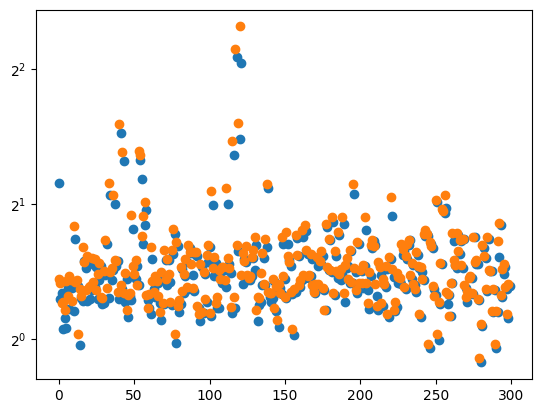

In [11]:
import matplotlib.pyplot as plt

plt.yscale('log',base=2) 
plt.scatter(range(0,global_epochs), diffPerRound)
plt.scatter(range(0,global_epochs-1), offset_diff_mean)
plt.show()

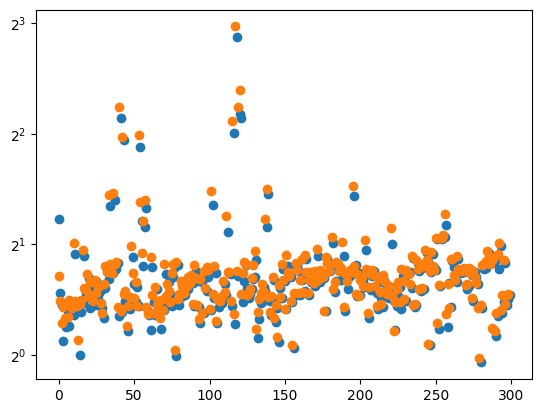

In [13]:
plt.yscale('log',base=2)
plt.scatter(range(0,global_epochs), max_dif)
plt.scatter(range(0,global_epochs-1), offset_max_dif)
plt.show()

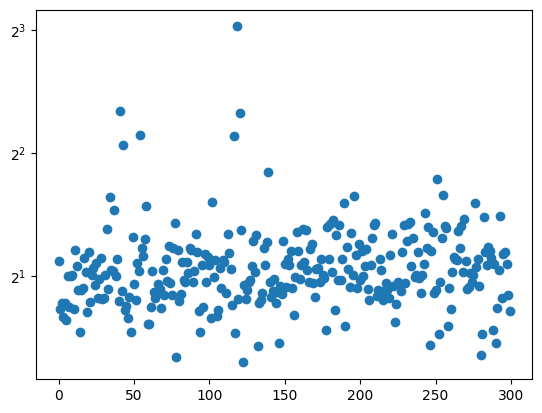

In [39]:
plt.yscale('log',base=2)
plt.scatter(range(0,global_epochs), inter_dif_per_round)
plt.show()

In [71]:
diff = [((l-g)**2).sum() for l,g in combo]
[t.shape for t in diff]


[torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([]),
 torch.Size([])]

In [64]:
diff[9].data

tensor(0.0034, device='cuda:6')